In [2]:
from multiprocessing import Pool, freeze_support, cpu_count
import os

import psutil

# you can use whatever, but your machine core count is usually a good choice (although maybe not the best)
#pool = Pool(cpu_count()) 

import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import json
import sys
import pickle
import numpy as np
from scipy.stats import poisson
import time
import sys
import pandas as pd



In [20]:
N_CPUS=10

In [4]:
def myfun(x):
    return np.log2(np.sqrt(x**-3))

pool = Pool(12) 
t = time.time()
A = pool.map(myfun, [i for i in range(1,300000)])
print(time.time()-t)


t = time.time()
A = [myfun(i) for i in range(1,300000)]
print(time.time()-t)

0.26660823822021484
1.1473095417022705


Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-21:
Process ForkPoolWorker-24:
Process ForkPoolWorker-14:
Process ForkPoolWorker-18:
Process ForkPoolWorker-20:
Process ForkPoolWorker-19:
Process ForkPoolWorker-15:
Process ForkPoolWorker-13:
Process ForkPoolWorker-17:
Process ForkPoolWorker-16:
Traceback (most recent call last):
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
Traceback (most recent call last):
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocess

In [5]:
from multiprocessing import Pool, freeze_support, cpu_count
import os

# you can use whatever, but your machine core count is usually a good choice (although maybe not the best)
pool = Pool(cpu_count()) 

#def wrapped_some_function_call(args): 
    """
#    we need to wrap the call to unpack the parameters 
    we build before as a tuple for being able to use pool.map
    """ 
#    sume_function_call(*args) 

#results = pool.map(wrapped_some_function_call, all_args)
#total_error = sum(results)

In [5]:
# Set up file locations.
IDX = 1
OUT_DIR = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/unmapped/'
KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/counts/unmapped_filt.tsv'
N_KMERS = 1000000 #1094247 # Number of kmers in KMER_COUNTS_FILE file

PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'


###################################################################
#################### Loading files. ##############################
###################################################################
print("Loading in files...")
# Load in family region/global region conversion data.
fam_region_to_idx = np.load(PHASINGS_DIR +  'fam_region_to_idx.npy', allow_pickle=True).item()
global_region_to_idx = np.load(PHASINGS_DIR +  'global_region_to_idx.npy', allow_pickle=True).item()
fam_idx_to_global_idx = np.load(PHASINGS_DIR + 'fam_regions_to_global_regions.npy', allow_pickle=True)
family_info = pd.read_pickle(PHASINGS_DIR + 'fam_list.df')

# Info from BAM mappings.
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']

# This sample is messed up in the unmapped reads, 
if 'unmapped' in KMER_COUNTS_FILE:
    bam_mappings = bam_mappings.drop('09C86428')

# Load in k-mer counts.
family = family_info.index[IDX]
print('family ', family)
samples = [family_info.iloc[IDX]['mother_sample'], family_info.iloc[IDX]['father_sample']] +  family_info.iloc[IDX]['sib_samples']
bam_mappings['counter_idx'] = [i for i in range(len(bam_mappings))]
cols_in_df = bam_mappings.loc[samples].counter_idx.values
print(samples)

###################################################################
#### Prep dict for normalizing k-counts by sample read depth. #####
###################################################################
kmer_length=100
ihart_flagstat_file = '/home/groups/dpwall/briannac/blood_microbiome/data/ihart_flagstat.csv'
flagstat = pd.read_csv(ihart_flagstat_file, index_col=0)
flagstat = flagstat.loc[set(flagstat.index).intersection(bam_mappings.index)]
sex = bam_mappings.loc[flagstat.index].sex_numeric
#bam_mappings = bam_mappings.loc[set(flagstat.index).intersection(bam_mappings.index)]
total_mapped_reads = flagstat.ProperPair*((flagstat.Total_Reads-flagstat.Supplementary-flagstat.Duplicates)/flagstat.Total_Reads)
avg_coverage = total_mapped_reads*150/(6.27e9*(sex.astype(float)==1.0) + 6.37e9*(sex.astype(float)==2.0))
avg_n_100mers = (150-kmer_length)/(150/avg_coverage)
kmer_depth_dict = {k:avg_n_100mers[k] if k in avg_n_100mers else np.mean(avg_n_100mers.values) for k in bam_mappings.index}
avg_k_depth = np.mean(list(kmer_depth_dict.values()))

###########################################################
####### Set up poisson cache and access function. ########
###########################################################
print("Setting up poisson cache...")
max_count = 40
eps = 1e-20
possible_repeats = {0,1,2,3,4,5}
with open('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/phased_fams_all.pickle', 'rb') as f:
    phased_fam_dict = pickle.load(f)
family_phasings = sorted(list(set([tuple(v) for v in phased_fam_dict[family].values])))
poisson_cache = {}
avg_kmer_depth=np.mean(list(kmer_depth_dict.values()))
for i in (possible_repeats):
    for j in possible_repeats:
        if j>i: 
            for k in range(max_count):
                prob = poisson.pmf(k=k, mu=int(i+j)*avg_kmer_depth)
                if prob>eps: poisson_cache[(i+j, k)] = prob
    
def cached_poisson_pmf(k,g):
    if (g==0) & (k!=0): return eps
    if (g==0) & (k==0): return 1-3*eps
    if (g,k) not in poisson_cache: return eps
    return min(max(poisson_cache[g,k], eps), 1-3*eps)

###########################################################
#### Computing phasing x global region Presence matrix ####
###########################################################
print("Computing phasing x global region presence matrix...")
family_phasings_to_idx_dict = {p:i for i,p in enumerate(family_phasings)}
global_regions_phasings_fam = np.zeros((len(global_region_to_idx),len(family_phasings))) 

for k,v in pd.DataFrame(phased_fam_dict[family].apply(lambda x: tuple(x), axis=1)).iterrows():
    for i in fam_idx_to_global_idx[fam_region_to_idx[k]]:
        global_regions_phasings_fam[i,family_phasings_to_idx_dict[v[0]]] = 1
        
# If we don't know the phasing, then default to most common phasing.
# Doing it this way will assign unknown regions the most common likelihood of the whole family's genome.
# If we didn't do this, we would end up with have the log-likelihood=0 at regions w/unknown phases, this will give unknown regions an unfair advantage.
impute_vector = np.zeros(len(family_phasings))
impute_vector[np.argmax(global_regions_phasings_fam.sum(axis=0))] = 1

#impute_vector = np.apply_along_axis(arr=global_regions_phasings_fam[np.where(global_regions_phasings_fam.sum(axis=1)!=0)[0], :], func1d=np.median, axis=0)
for i in np.where(global_regions_phasings_fam.sum(axis=1)==0)[0]:
    global_regions_phasings_fam[i,:]=impute_vector
 

print("Computing phasing x k-mer region likelihood matrix...")
phases_kmers_L = np.zeros((N_KMERS,len(family_phasings)))  # Initialize likelihood matrix (phases as rows, kmers as columns)

Loading in files...
family  AU0012
['04C24230', '04C24231', '04C24232', '04C24233']
Setting up poisson cache...
Computing phasing x global region presence matrix...
Computing phasing x k-mer region likelihood matrix...


In [30]:
# Read in kmer counts file. (Hacky way to fix some differences between unmapped reads & synthetic datasets.)
if 'unmapped' in KMER_COUNTS_FILE: # Unmappd data has no header.
    chunks = pd.read_table(KMER_COUNTS_FILE, header=None,  chunksize=10000, usecols=1+cols_in_df, nrows=N_KMERS, dtype=int)
elif 'decoy' in KMER_COUNTS_FILE: # Decoy data has no header.
    chunks = pd.read_table(KMER_COUNTS_FILE, header=None,  chunksize=100000, usecols=1+cols_in_df, nrows=N_KMERS)
else: # synthetic dataset has header with samples.
    chunks = pd.read_table(KMER_COUNTS_FILE, chunksize=100000, nrows=N_KMERS,usecols=samples)    
  

In [31]:
def prob_product(k_cs, k_m, k_p, phases_ch_compute,possible_gs_mom,possible_gs_dad):
    max_so_far = 0
    for g_m in possible_gs_mom:
        for g_p in iter(possible_gs_dad):
            A = cached_poisson_pmf(k_m,sum(g_m))*cached_poisson_pmf(k_p,sum(g_p))
            for k_c, phase_ch in zip(iter(k_cs), iter(phases_ch_compute)):
                if A <= max_so_far: break
                A=A*cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]])
            max_so_far = max(A,max_so_far)
    return max_so_far


for kmer_counts in chunks:
    if ('unmapped' in KMER_COUNTS_FILE) or ('decoy' in KMER_COUNTS_FILE):
        kmer_counts = kmer_counts[1+cols_in_df]
        kmer_counts.columns = samples
    print(len(kmer_counts), 'kmer counts')
    print(kmer_counts.index[0])
    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
    kmer_counts = kmer_counts[((kmer_counts).sum(axis=1)>0)]
    kmer_counts_normed = kmer_counts.apply(lambda x: x*norm_mult, axis=1)
    kmer_counts_normed = kmer_counts_normed.apply(lambda x: np.round(x/(10**np.floor(np.log10(max(x[x>0]))))), axis=1).astype(int)
    kmer_counts_normed = kmer_counts_normed.applymap(lambda x: min(x,max_count))
    poss_kmer_counts = set([tuple(v) for v in kmer_counts_normed.values])
    family_probability_cache = dict()
    print(len(poss_kmer_counts), 'unique kmer counts')
    
    
    for phases_ch in tqdm(family_phasings):
        # If X chromosome:
        if (max([f for ff in phases_ch for f in ff]) > 3) & (max([f for ff in phases_ch for f in ff]) < 8):
            phases_ch_compute = [(f-4,g-4) for f,g in phases_ch]
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] # Include possible repeats!
            possible_gs_dad = [(mat_gt,0) for mat_gt in possible_repeats]

        # If Y chromosome:
        elif (max([f for ff in phases_ch for f in ff]) > 7):
            phases_ch_compute = [(f-8,g-8) for f,g in phases_ch]
            possible_gs_mom = [(0,0)] 
            possible_gs_dad = [(0,pat_gt) for pat_gt in possible_repeats]

            
        # Autosome or PAR
        else :
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] 
            possible_gs_dad = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] 
            phases_ch_compute =  phases_ch
        
        t = time.time()
        
        # Parallelize across this function.
        def myfunc(kmer_count_set):
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            return ((k_m, k_p, *k_cs), round(np.log2(prob_product(k_cs, k_m, k_p, phases_ch_compute,iter(possible_gs_mom),possible_gs_dad)),3))

        pool = Pool(N_CPUS)
        family_probability_cache.update({(k, phases_ch):v for k,v in pool.map(myfunc,poss_kmer_counts)})

        break
    break
    print('Done making cached dictionary.')
    # Compute likelihood matrix (phasings x kmers)
    for i,p in enumerate(family_phasings):
        phases_kmers_L[kmer_counts_normed.index, i] = [family_probability_cache[(k, p)] for k in kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values]
    print('Done compute likelihood matrix')

10000 kmer counts
0





  0%|          | 0/7 [00:00<?, ?it/s]

187 unique kmer counts
time 5.749123811721802


In [34]:
A==B

True

In [15]:
t= time.time()
    def myfunc(kmer_count_set):
        k_m = kmer_count_set[0]
        k_p = kmer_count_set[1]
        k_cs = kmer_count_set[2:]
        return ((k_m, k_p, *k_cs), round(np.log2(prob_product(k_cs, k_m, k_p, phases_ch_compute,iter(possible_gs_mom),possible_gs_dad)),3))
    
pool = Pool(N_CPUS)
family_probability_cache.update({(k, phases_ch):v for k,v in pool.map(myfunc,poss_kmer_counts)})

print(time.time()-t)
family_probability_cache = dict()
t = time.time()
family_probability_cache.update({(k, phases_ch):v for k,v in [myfunc(p) for p in poss_kmer_counts]})

print(t-time.time())

3.856013298034668
-22.87994122505188


Process ForkPoolWorker-41:
Process ForkPoolWorker-40:
Process ForkPoolWorker-38:
Process ForkPoolWorker-42:
Process ForkPoolWorker-37:
Process ForkPoolWorker-43:
Process ForkPoolWorker-39:
Traceback (most recent call last):
Process ForkPoolWorker-45:
Process ForkPoolWorker-48:
Process ForkPoolWorker-44:
Process ForkPoolWorker-47:
Process ForkPoolWorker-46:
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/share/software/user/open/python/3.6.1/lib/python3.6/multiprocessing/synchronize.py", line 96, in __

In [14]:
t = time.time()
family_probability_cache = {(k, phases_ch):v for k,v in [myfunc(p) for p in poss_kmer_counts]}

print(t-time.time())

-22.681771755218506


In [15]:
t= time.time()
if True:
    for kmer_count_set in poss_kmer_counts:
        k_m = kmer_count_set[0]
        k_p = kmer_count_set[1]
        k_cs = kmer_count_set[2:]
        family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(prob_product(k_cs, k_m, k_p, phases_ch_compute,iter(possible_gs_mom),possible_gs_dad)),3)
print(time.time()-t)

23.306803226470947


In [177]:
from operator import mul
def prob_product(k_cs, phases_ch_compute,possible_gs_mom,possible_gs_dad):
    max_so_far = 0
    for g_m in possible_gs_mom:
        for g_p in iter(possible_gs_dad):
            A = cached_poisson_pmf(k_m,sum(g_m))*cached_poisson_pmf(k_p,sum(g_p))
            for k_c, phase_ch in zip(iter(k_cs), iter(phases_ch_compute)):
                if A <= max_so_far: break
                A=A*cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]])
            max_so_far = max(A,max_so_far)
    return max_so_far
    

In [176]:
gs_mom = [list(possible_gs_mom)[0]]
gs_dad = [list(possible_gs_dad)[0]]

t = time()
B = np.log2(max([cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_m in possible_gs_mom for g_p in possible_gs_dad]))
print(time()-t)

t = time()
A = np.log2(prob_product(k_cs, phases_ch_compute, iter(possible_gs_mom), possible_gs_dad))
print(time()-t)


print(B)
print(A)


0.05649375915527344
0.022547245025634766
-13.859750084662844
-13.859750084662844


In [143]:
k_p

2

In [158]:
gs_mom = [list(possible_gs_mom)[0]]
gs_dad = [list(possible_gs_dad)[0]]

t = time()
B = np.log2(max([cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_m in possible_gs_mom for g_p in possible_gs_dad]))
print(time()-t)


t = time()
A = np.log2(max([cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_m in possible_gs_mom for g_p in possible_gs_dad]))
A = np.log2(prob_product(k_cs, phases_ch_compute, iter(possible_gs_mom), iter(possible_gs_dad)))
print(time()-t)


print(B)
print(A)


0.05660653114318848
0.05939459800720215
-13.859750084662844
-77.69698379215937


In [151]:
np.log2(.00234)

-8.739275754853407

In [155]:
print(B)
print(A)

-13.859750084662844
-13.859750084662844


In [82]:
A = 1
t = time()
A = np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)])



A = 1
t = time()
A = np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)])
print(time()-t)

0.00017142295837402344
0.00020194053649902344


In [ ]:
GetProduce()

In [73]:
gs_mom = [list(possible_gs_mom)[0]]
gs_dad = [list(possible_gs_dad)[0]]

t = time()

my_array = [A for A]
A = np.log2(max([cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_m in possible_gs_mom for g_p in possible_gs_dad]))
print(time()-t)


my_array = [A for A]
A = np.log2(max([cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_m in possible_gs_mom for g_p in possible_gs_dad]))
print(time()-t)

0.00044345855712890625


In [65]:
gs_mom = {list(possible_gs_mom)[0]}
gs_dad = {list(possible_gs_dad)[0]}

t = time()
A = [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_m in gs_mom for g_p in gs_dad]
print(time()-t)

0.00027561187744140625


In [67]:
possible_gs_dad

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

In [56]:
t = time()
A = [cached_poisson_pmf(k_m,sum(g_m)) for g_m in possible_gs_mom for g_p in possible_gs_dad]#[cached_poisson_pmf(k_m,sum(g_m))*
             #    cached_poisson_pmf(k_p,sum(g_p))*
              #   np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
              #          ) for g_m in possible_gs_mom for g_p in possible_gs_dad]
print(time()-t)

0.00011086463928222656


In [52]:
t = time()
max(A)
print(time()-t)

5.793571472167969e-05


In [32]:
chunks = pd.read_table(KMER_COUNTS_FILE, chunksize=10000, nrows=N_KMERS, usecols=cols_in_df+1, header=None)

In [33]:
for c in chunks: break

In [34]:
c

,899,900,901,902
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
9995,9,9,10,14
9996,9,9,9,13
9997,9,9,9,13
9998,8,8,9,13


In [1]:
   
for kmer_counts in chunks:
    if 'unmapped' in KMER_COUNTS_FILE:
        kmer_counts = kmer_counts[1+cols_in_df]
        kmer_counts.columns = samples
    print(kmer_counts.index[0])
    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
    kmer_counts = kmer_counts[((kmer_counts>0).sum(axis=1)>0)]
    kmer_counts_normed = kmer_counts.apply(lambda x: x*norm_mult, axis=1)
    kmer_counts_normed = kmer_counts_normed.apply(lambda x: np.round(x/(10**np.floor(np.log10(max(x[x>0]))))), axis=1).astype(int)
    kmer_counts_normed = kmer_counts_normed.applymap(lambda x: min(x,max_count))
    poss_kmer_counts = set([tuple(v) for v in kmer_counts_normed.values])
    family_probability_cache = dict()
    
    for phases_ch in family_phasings:
        print(phases_ch)
        # If X chromosome:
        if (max([f for ff in phases_ch for f in ff]) > 3) & (max([f for ff in phases_ch for f in ff]) < 8):
            phases_ch_compute = [(f-4,g-4) for f,g in phases_ch]
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] # Include possible repeats!
            possible_gs_dad = [(mat_gt,0) for mat_gt in possible_repeats]

        # If Y chromosome:
        elif (max([f for ff in phases_ch for f in ff]) > 7):
            phases_ch_compute = [(f-8,g-8) for f,g in phases_ch]
            possible_gs_mom = [(0,0)] 
            possible_gs_dad = [(0,pat_gt) for pat_gt in possible_repeats]

            
        # Autosome or PAR
        else :
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] 
            possible_gs_dad = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] 
            phases_ch_compute =  phases_ch
        
        print(len(poss_kmer_counts))
        for kmer_count_set in (poss_kmer_counts):
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(np.max(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_m in possible_gs_mom for g_p in possible_gs_dad])),3)

    print('Done making cached dictionary.')
    # Compute likelihood matrix (phasings x kmers)
    for i,p in enumerate(family_phasings):
        phases_kmers_L[kmer_counts_normed.index, i] = [family_probability_cache[(k, p)] for k in kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values]
    print('Done compute likelihood matrix')
    

###########################################################
#################### Saving data ##########################
###########################################################
print("Done computing phasing x k-mer matrix for family!")
print("Saving...")
np.savetxt(OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX, phases_kmers_L, delimiter='\t', fmt='%.3f')
print('saved to ', OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX)

#np.savetxt(OUT_DIR + 'global_regions_phasings_fam%03d.tsv' % IDX, global_regions_phasings_fam, delimiter='\t', fmt='%.0f')
#print('saved to ', OUT_DIR +  'global_regions_phasings_fam%03d.tsv' % IDX)

In [2]:
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']
#bam_mappings = bam_mappings.drop('09C86428')

In [24]:
synthetic_data = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/data/counts/synthetic_data_1_repeats_all.tsv')
np.mean(synthetic_data[['04C24230', '04C24231', '04C24232', '04C24233']].sum(axis=1)>0)

0.649

In [4]:
bam_mappings.loc[['04C24230', '04C24231', '04C24232', '04C24233']].sex_numeric

sample_id
04C24230    2.0
04C24231    1.0
04C24232    1.0
04C24233    1.0
Name: sex_numeric, dtype: object

In [3]:
true_locs = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/data/counts/synthetic_data_locations_all.txt', header=None)
# Read in predicted and true locations.
true_locs['chrom'] = true_locs[0].apply(lambda x: x.split('.')[0])
true_locs['start'] = true_locs[0].apply(lambda x: int(x.split('.')[1]))
true_locs['end'] = true_locs[0].apply(lambda x: int(x.split('.')[2]))
true_locs['prev'] = true_locs[1]
true_locs = true_locs[['chrom', 'start', 'end', 'prev']]


In [4]:
true_locs

,chrom,start,end,prev
0,YY,0,100,0.374540
1,YY,0,100,0.950714
2,YY,0,100,0.731994
3,YY,0,100,0.598658
4,YY,0,100,0.156019
...,...,...,...,...
100995,10,103485596,103486526,0.784562
100996,03,184100629,184100723,0.183026
100997,05,67681304,67697452,0.014864
100998,04,139012306,139046702,0.736811


In [45]:
# Single family.
likelihood_matrix_phasings_kmers_fam1 = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data1/'
                                                 + 'likelihood_matrix_phasings_kmers_fam001.tsv',
                                                 header = None, nrows=10000)#.iloc[true_locs[true_locs.chrom=='XX'].index[:30]]
#likelihood_matrix_phasings_kmers_fam1.sum(axis=0)

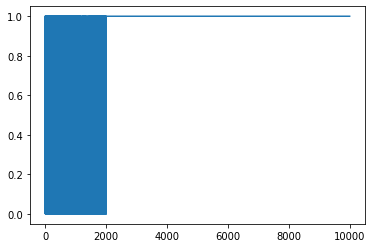

In [44]:
plt.plot(likelihood_matrix_phasings_kmers_fam1.sum(axis=1)==0)

In [9]:
likelihood_matrix_phasings_kmers_fam1 = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data10/'
                                                 + 'likelihood_matrix_phasings_kmers_fam001.tsv',
                                                 header = None, nrows=10000)#.iloc[true_locs[true_locs.chrom=='XX'].index[:30]]
likelihood_matrix_phasings_kmers_fam1

,0,1,2,3,4,5,6
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,-8.107,-12.525,-8.107,-12.525,-16.525,-24.943,-8.107
2,-8.107,-12.525,-8.107,-12.525,-16.525,-24.943,-8.107
3,-10.571,-13.989,-10.571,-13.989,-18.989,-27.407,-10.571
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...
9995,-23.493,-30.911,-30.911,-23.493,-23.493,-30.911,-84.058
9996,-21.948,-28.366,-29.366,-21.948,-21.948,-29.366,-82.514
9997,-20.164,-20.164,-11.746,-11.746,-20.164,-11.746,-89.148
9998,-2.642,-2.642,-11.060,-11.060,-2.642,-11.060,-66.439


In [5]:
# Cummulative Likelihoods
global_regions_phasings = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data1/' + 
                                        'global_regions_phasings.tsv', header=None)
likelihood_matrix_phasings_kmers = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data1/'
                                                 + 'likelihood_matrix_phasings_kmers.tsv',
                                                 header = None)
cum_likelihoods_y = np.matmul(likelihood_matrix_phasings_kmers.values[:100],global_regions_phasings.transpose().values)
cum_likelihoods_autosome = np.matmul(likelihood_matrix_phasings_kmers.values[1000:1100],global_regions_phasings.transpose().values)


KeyboardInterrupt: 

chrom          01
start     4048520
end       4052566
prev     0.540567
Name: 1020, dtype: object


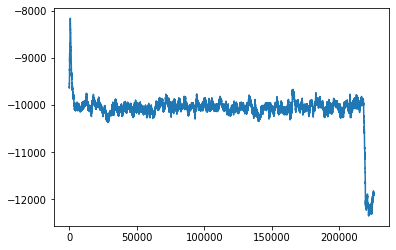

chrom          05
start    14920198
end      14952034
prev     0.369097
Name: 1021, dtype: object


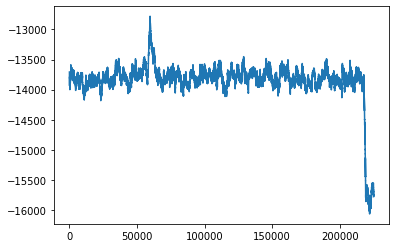

chrom           18
start     72653516
end       72697677
prev     0.0181355
Name: 1022, dtype: object


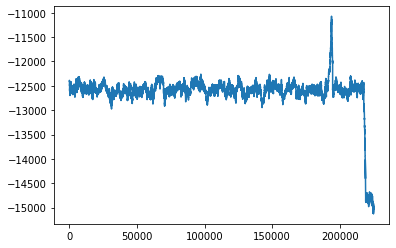

chrom           05
start    112631360
end      112631869
prev      0.643539
Name: 1023, dtype: object


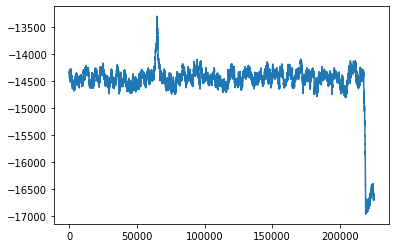

chrom          19
start    44578506
end      44579444
prev     0.565936
Name: 1024, dtype: object


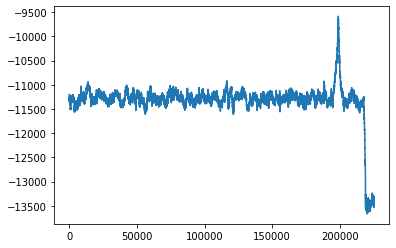

chrom          01
start    65233201
end      65233202
prev     0.978256
Name: 1025, dtype: object


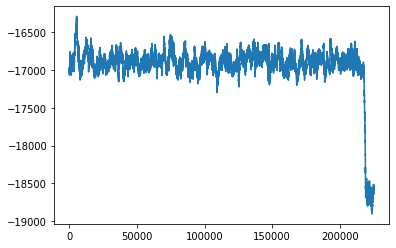

chrom          08
start    85508188
end      85530906
prev     0.507967
Name: 1026, dtype: object


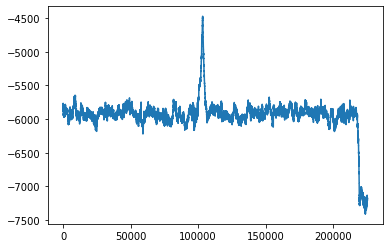

chrom          22
start    22224738
end      22224948
prev     0.534948
Name: 1027, dtype: object


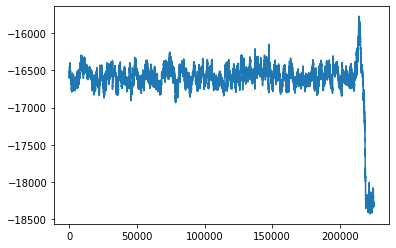

chrom          17
start    40119073
end      40196126
prev     0.282262
Name: 1028, dtype: object


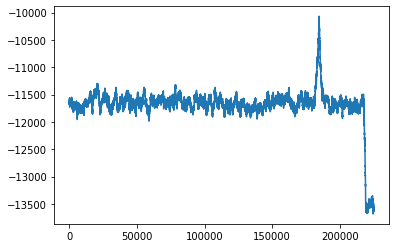

chrom           06
start    164122206
end      164147006
prev     0.0995991
Name: 1029, dtype: object


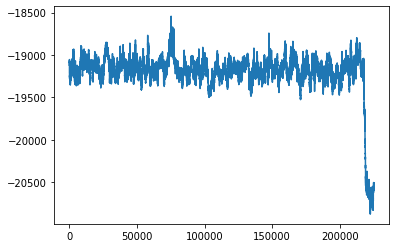

In [7]:
for i in range(20,30):
    print(true_locs.iloc[1000+i])
    plt.plot(cum_likelihoods_autosome[i][:-1])
    plt.show()

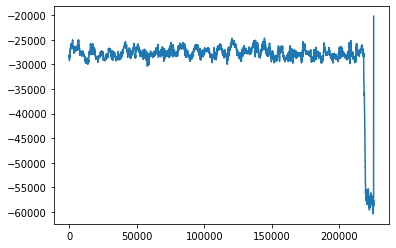

In [95]:
plt.plot(cum_likelihoods_y.sum(axis=0), '-')

In [49]:
# Single family.
likelihood_matrix_phasings_kmers_fam1 = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data1/'
                                                 + 'likelihood_matrix_phasings_kmers_fam001.tsv',
                                                 header = None, nrows=10000)#.iloc[true_locs[true_locs.chrom=='XX'].index[:30]]
#likelihood_matrix_phasings_kmers_fam1.sum(axis=0)

In [56]:
(likelihood_matrix_phasings_kmers_fam1.iloc[:1000].sum())

0   -7667.805
1   -5538.051
2   -6413.523
3   -5538.051
4   -9250.389
5   -6413.523
6   -9082.029
dtype: float64

In [55]:
50/4

12.5

In [10]:
# Cummulative Likelihoods
global_regions_phasings = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data10/' + 
                                        'global_regions_phasings.tsv', header=None)
likelihood_matrix_phasings_kmers = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data10/'
                                                 + 'likelihood_matrix_phasings_kmers.tsv',
                                                 header = None)
cum_likelihoods_y = np.matmul(likelihood_matrix_phasings_kmers.values[:100],global_regions_phasings.transpose().values)
cum_likelihoods_autosome = np.matmul(likelihood_matrix_phasings_kmers.values[1000:1100],global_regions_phasings.transpose().values)

In [11]:
cum_likelihoods_y = np.matmul(likelihood_matrix_phasings_kmers.values[:100],global_regions_phasings.transpose().values)
cum_likelihoods_autosome = np.matmul(likelihood_matrix_phasings_kmers.values[1000:1100],global_regions_phasings.transpose().values)

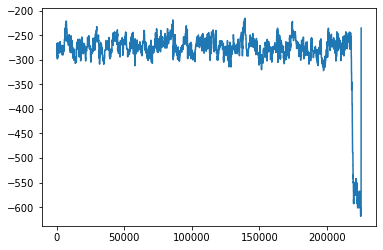

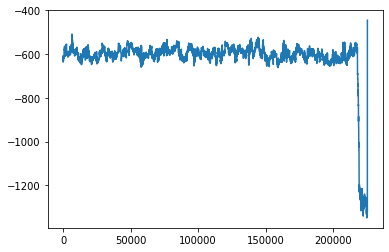

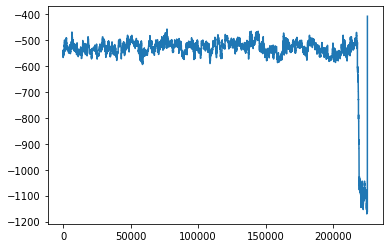

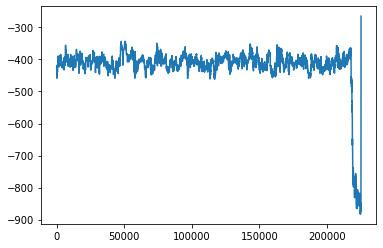

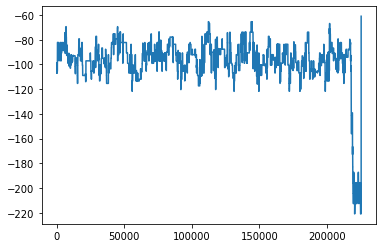

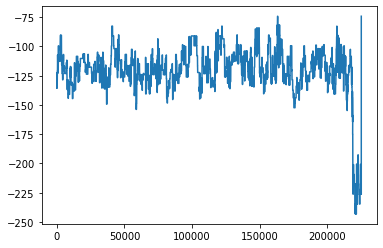

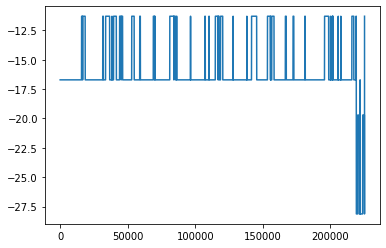

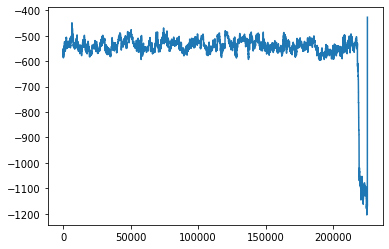

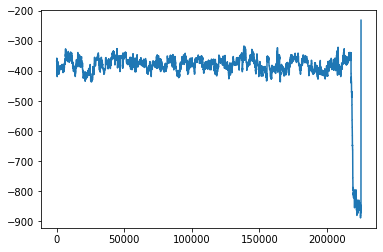

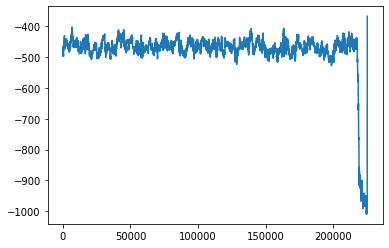

In [16]:
for i in range(10):
    plt.plot(cum_likelihoods_y[i], '-')
    plt.show()

chrom          15
start    50216622
end      50216624
prev     0.796472
Name: 1010, dtype: object


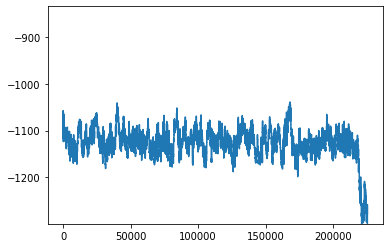

chrom          07
start    12033455
end      12035994
prev     0.459347
Name: 1011, dtype: object


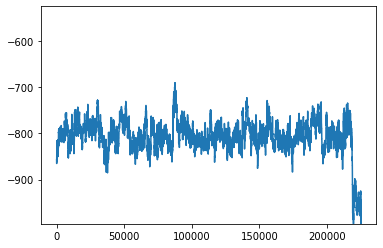

chrom          09
start    78585841
end      78602580
prev     0.842091
Name: 1012, dtype: object


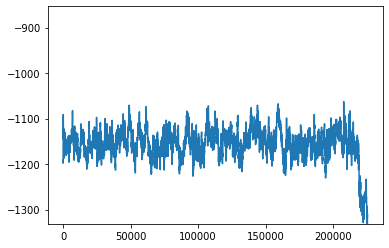

chrom           10
start    119829891
end      119830262
prev      0.768918
Name: 1013, dtype: object


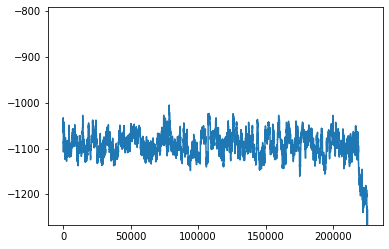

chrom          16
start    17753991
end      17754078
prev     0.066236
Name: 1014, dtype: object


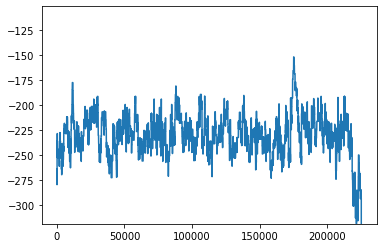

chrom           18
start     32177947
end       32181983
prev     0.0458613
Name: 1015, dtype: object


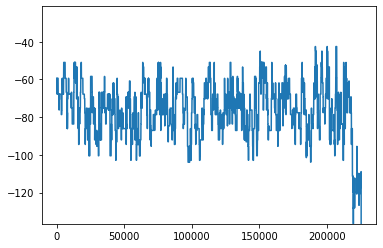

chrom           01
start    244195793
end      244198502
prev      0.620806
Name: 1016, dtype: object


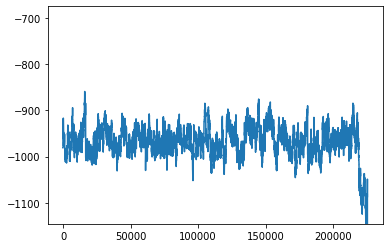

chrom           03
start    145354791
end      145355184
prev      0.347413
Name: 1017, dtype: object


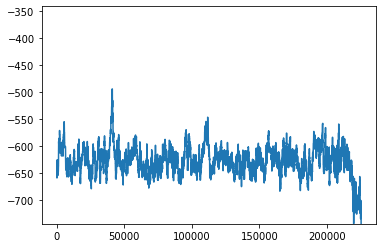

chrom           05
start    154198630
end      154203253
prev      0.209131
Name: 1018, dtype: object


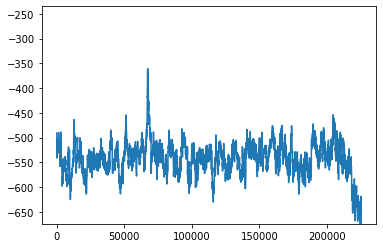

chrom           05
start    110022080
end      110033316
prev       0.57965
Name: 1019, dtype: object


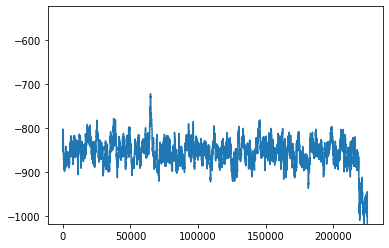

In [26]:
for i in range(10,20):
    plt.plot(cum_likelihoods_autosome[i], '-')
    print(true_locs.iloc[1000+i])
    plt.ylim(min(cum_likelihoods_autosome[i][:-1]),)
    plt.show()

In [91]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm


N = 1000 # Number of locations to be simulated.
np.random.seed(42)

# Load bam_mappings metadata file.
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')


# Load phasings information.
PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'
OUT_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/counts/'

fam_region_to_idx = np.load(PHASINGS_DIR +  'fam_region_to_idx.npy', allow_pickle=True).item()
fam_idx_to_region = np.load(PHASINGS_DIR +  'idx_to_fam_region.npy', allow_pickle=True).item()
global_region_to_idx = np.load(PHASINGS_DIR +  'global_region_to_idx.npy', allow_pickle=True).item()
fam_idx_to_global_idx = np.load(PHASINGS_DIR + 'fam_regions_to_global_regions.npy', allow_pickle=True)
global_idx_to_fam_idx = np.load(PHASINGS_DIR + 'global_region_to_fam_regions.npy', allow_pickle=True)
family_info = pd.read_pickle(PHASINGS_DIR + 'fam_list.df')

# Get random locations.
locations = np.random.choice([list(global_region_to_idx.keys())[-1]], N, replace=True)
freqs = np.random.random(N)
location_idxs = [global_region_to_idx[l] for l in locations]
fam_regions = [[fam_idx_to_region[g] for g in global_idx_to_fam_idx[i]] for i in location_idxs]


# Save locations to file.
with open(OUT_DIR + 'synthetic_data_locations.txt', 'w') as f:
    for l,fr in zip(locations, freqs):
        f.writelines(l + '\t' + str(fr) + '\n')
        
        
# Get k-mer depth dictionary.
kmer_length=100
ihart_flagstat_file = '/home/groups/dpwall/briannac/blood_microbiome/data/ihart_flagstat.csv'
flagstat = pd.read_csv(ihart_flagstat_file, index_col=0)
flagstat = flagstat.loc[set(flagstat.index).intersection(bam_mappings.index)]
sex = bam_mappings.loc[flagstat.index].sex_numeric
total_mapped_reads = flagstat.ProperPair*((flagstat.Total_Reads-flagstat.Supplementary-flagstat.Duplicates)/flagstat.Total_Reads)
avg_coverage = total_mapped_reads*150/(6.27e9*(sex.astype(float)==1.0) + 6.37e9*(sex.astype(float)==2.0))
avg_n_100mers = (150-kmer_length)/(150/avg_coverage)
kmer_depth_dict = {k:avg_n_100mers[k] if k in avg_n_100mers else np.mean(avg_n_100mers.values) for k in bam_mappings.index}


with open('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/phased_fams_all.pickle', 'rb') as f:
    phased_fam_dict = pickle.load(f)
        
# Simulate k-mer counts.
for REPEAT_AVG in [1,10,100]:
    print(REPEAT_AVG)
    counts = pd.DataFrame(np.zeros((N,len(bam_mappings))), columns=bam_mappings.index) + np.nan


    for fam in tqdm(list(phased_fam_dict.keys())):
        if fam not in family_info.index: continue
        mother_sample = family_info.loc[fam].mother_sample
        father_sample = family_info.loc[fam].father_sample
        children_samples = family_info.loc[fam].sib_samples

        current_fam_regions = [set(f).intersection(phased_fam_dict[fam].index) for f in fam_regions]
        current_fam_regions = [list(c)[0] if len(c)==1 else np.random.choice(phased_fam_dict[fam].index) for c in current_fam_regions]
        phased_fam = phased_fam_dict[fam].loc[current_fam_regions][children_samples].values
        phased_fam = np.array([[(p[0]%4, p[1]%4) for p in pp] for pp in phased_fam])
        
        if REPEAT_AVG == 1:
            mom_g1 = (np.random.random(N)<=freqs)*1
            dad_g1 = (np.random.random(N)<=freqs)*1
            mom_g2 = (np.random.random(N)<=freqs)*1
            dad_g2 = (np.random.random(N)<=freqs)*1
        else:
            mom_g1 = (np.random.random(N)<=freqs)*np.random.poisson(REPEAT_AVG, N)
            dad_g1 = (np.random.random(N)<=freqs)*np.random.poisson(REPEAT_AVG, N)
            mom_g2 = (np.random.random(N)<=freqs)*np.random.poisson(REPEAT_AVG, N)
            dad_g2 = (np.random.random(N)<=freqs)*np.random.poisson(REPEAT_AVG, N)

        # Correct for X and Y chromsomes.
        dad_g2 = [0 if 'X' in r else g for g,r in zip(dad_g2, current_fam_regions)]
        
        mom_g1 = [0 if 'Y' in r else g for g,r in zip(mom_g1, current_fam_regions)]
        mom_g2 = [0 if 'Y' in r else g for g,r in zip(mom_g2, current_fam_regions)]
        dad_g1 = [0 if 'Y' in r else g for g,r in zip(dad_g1, current_fam_regions)]
        
        
        # Simulate parent's genotypes based on phasing and simulated info about sequence.
        mom_gts = np.array([mom_g1, mom_g2]).transpose()
        dad_gts = np.array([dad_g1, dad_g2]).transpose()

        # Simulate counts based on genotype and phasing.
        mom_counts = mom_g1*np.random.poisson(5, N)+mom_g2*np.random.poisson(5, N)
        dad_counts = dad_g1*np.random.poisson(5, N)+dad_g2*np.random.poisson(5, N)
        children_counts = [[
            kmer_depth_dict[children_samples[ch_idx]] * 
            (mom_gts[region_idx,phased_fam[region_idx, ch_idx][0]] + 
             dad_gts[region_idx,phased_fam[region_idx, ch_idx][1]])
                            for ch_idx in range(phased_fam.shape[1])] for region_idx in range(phased_fam.shape[0])]
        
        # Update total dataframe
        counts[mother_sample] = mom_counts
        counts[father_sample] = dad_counts
        counts[children_samples] = children_counts

  2%|▏         | 13/727 [00:00<00:05, 125.78it/s]

1


  2%|▏         | 13/727 [00:00<00:05, 124.29it/s]

10


  2%|▏         | 13/727 [00:00<00:05, 125.20it/s]

100


100%|██████████| 727/727 [00:06<00:00, 108.03it/s]


In [96]:
counts

sample_id,02C10540,02C10541,02C10542,02C10543,02C10702,02C10704,02C10855,02C10856,02C10857,02C10858,...,MH0138052,MH0138054,MH0138055,MH0138989,MH0143008,MH0143009,MH0143013,MH0143018,MH0143019,09C86428
0,0,0,0.0,0.000000,NaN,NaN,0.0,0,0.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,0,0.0,624.279348,NaN,NaN,0.0,0,544.096527,666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,747,0,0.0,545.423009,NaN,NaN,0.0,0,0.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0,0,0.0,0.000000,NaN,NaN,0.0,0,0.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,0,0.0,0.000000,NaN,NaN,0.0,0,0.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0.0,0.000000,NaN,NaN,0.0,0,509.784134,624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
96,420,0,0.0,689.992963,NaN,NaN,0.0,0,0.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
97,490,0,0.0,643.993432,NaN,NaN,0.0,0,0.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
98,0,0,0.0,0.000000,NaN,NaN,0.0,0,0.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [85]:
bam_mappings.loc['02C10704'][['sex_numeric', 'relationship', 'family']]

sex_numeric         1.0
relationship    sibling
family           AU1004
Name: 02C10704, dtype: object

In [19]:
for child in children:
    if bam_mappings.loc[child].sex_numeric=='1.0':
        phased_fam[child] = [(i,5) if j==4 else (i,j) for i,j in phased_fam[child].values]
    if bam_mappings.loc[child].sex_numeric=='2.0':
        phased_fam[child] = [(i,4) if j==5 else (i,j) for i,j in phased_fam[child].values]


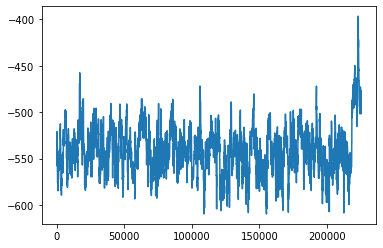

In [220]:
plt.plot(cum_likelihoods[75][:-1])

In [105]:
likelihood_matrix_phasings_kmers_fam = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data10/'
                                                 + 'likelihood_matrix_phasings_kmers_fam012.tsv',
                                                 header = None)


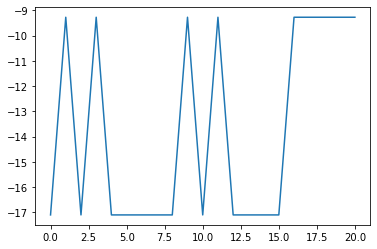

In [110]:
plt.plot(likelihood_matrix_phasings_kmers_fam.iloc[200])

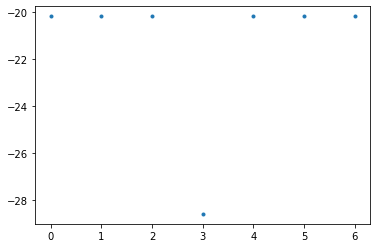

In [159]:
plt.plot(likelihood_matrix_phasings_kmers_fam1.iloc[10], '.')

In [16]:
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')
kmers =  pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/kmers_unmapped_filt_counts.tsv',
                       header=None, nrows=1000,index_col=0)
kmers.columns = bam_mappings.index


In [18]:
likelihood_matrix_phasings_kmers = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data1/'
                                                 + 'likelihood_matrix_phasings_kmers.tsv',
                                                 header = None, nrows=1000)

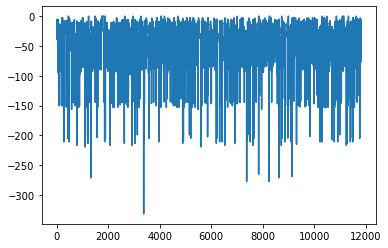

In [40]:
plt.plot(likelihood_matrix_phasings_kmers.iloc[0])

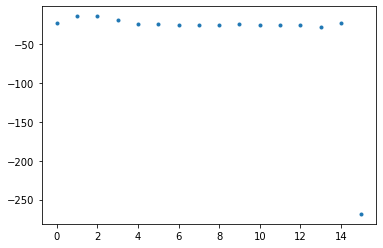

In [10]:
plt.plot(likelihood_matrix_phasings_kmers_fam1.iloc[0], '.')

In [20]:
"/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data100/" + 'likelihood_matrix_phasings_kmers.tsv'

'/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data100/likelihood_matrix_phasings_kmers.tsv'

# Single Family

In [188]:
global_regions_phasings_fam = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data1/' + 
                                        'global_regions_phasings_fam000.tsv', header=None)
likelihood_matrix_phasings_kmers_fam = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/synthetic_data1/'
                                                 + 'likelihood_matrix_phasings_kmers_fam000.tsv',
                                                 header = None)
cum_likelihoods = np.matmul(likelihood_matrix_phasings_kmers.values[:100],global_regions_phasings.transpose().values)

In [190]:
cum_likelihoods = np.matmul(likelihood_matrix_phasings_kmers.values[:100],global_regions_phasings.transpose().values)

NameError: name 'likelihood_matrix_phasings_kmers' is not defined

In [456]:
Counter(likelihood_matrix_phasings_kmers_fam.apply(np.argmax, axis=1)).most_common()

[(0, 985), (1, 11), (2, 4)]

In [23]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm


N = 100 # Number of locations to be simulated.
np.random.seed(42)

# Load bam_mappings metadata file.
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')


# Load phasings information.
PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'
OUT_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/counts/'

fam_region_to_idx = np.load(PHASINGS_DIR +  'fam_region_to_idx.npy', allow_pickle=True).item()
fam_idx_to_region = np.load(PHASINGS_DIR +  'idx_to_fam_region.npy', allow_pickle=True).item()
global_region_to_idx = np.load(PHASINGS_DIR +  'global_region_to_idx.npy', allow_pickle=True).item()
fam_idx_to_global_idx = np.load(PHASINGS_DIR + 'fam_regions_to_global_regions.npy', allow_pickle=True)
global_idx_to_fam_idx = np.load(PHASINGS_DIR + 'global_region_to_fam_regions.npy', allow_pickle=True)
family_info = pd.read_pickle(PHASINGS_DIR + 'fam_list.df')

# Get random locations.
locations = np.random.choice(list(global_region_to_idx.keys()), N, replace=True)
freqs = np.random.random(N)
location_idxs = [global_region_to_idx[l] for l in locations]
fam_regions = [[fam_idx_to_region[g] for g in global_idx_to_fam_idx[i]] for i in location_idxs]


# Save locations to file.
with open(OUT_DIR + 'synthetic_data_locations.txt', 'w') as f:
    for l,fr in zip(locations, freqs):
        f.writelines(l + '\t' + str(fr) + '\n')
        
        
# Get k-mer depth dictionary.
kmer_length=100
ihart_flagstat_file = '/home/groups/dpwall/briannac/blood_microbiome/data/ihart_flagstat.csv'
flagstat = pd.read_csv(ihart_flagstat_file, index_col=0)
flagstat = flagstat.loc[set(flagstat.index).intersection(bam_mappings.index)]
sex = bam_mappings.loc[flagstat.index].sex_numeric
total_mapped_reads = flagstat.ProperPair*((flagstat.Total_Reads-flagstat.Supplementary-flagstat.Duplicates)/flagstat.Total_Reads)
avg_coverage = total_mapped_reads*150/(6.27e9*(sex.astype(float)==1.0) + 6.37e9*(sex.astype(float)==2.0))
avg_n_100mers = (150-kmer_length)/(150/avg_coverage)
kmer_depth_dict = {k:avg_n_100mers[k] if k in avg_n_100mers else np.mean(avg_n_100mers.values) for k in bam_mappings.index}

# Simulate k-mer counts.
for REPEAT_AVG in [1,10,100]:
    print(REPEAT_AVG)
    counts = pd.DataFrame(np.zeros((N,len(bam_mappings))), columns=bam_mappings.index)

    with open('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/phased_fams_all.pickle', 'rb') as f:
        phased_fam_dict = pickle.load(f)

    for fam in tqdm(list(phased_fam_dict.keys())):
        if fam not in family_info.index: continue
        mother_sample = family_info.loc[fam].mother_sample
        father_sample = family_info.loc[fam].father_sample
        children_samples = family_info.loc[fam].sib_samples

        current_fam_regions = [set(f).intersection(phased_fam_dict[fam].index) for f in fam_regions]
        current_fam_regions = [list(c)[0] if len(c)==1 else np.random.choice([phased_fam_dict[fam].index[-1]]) for c in current_fam_regions]
        phased_fam = phased_fam_dict[fam].loc[current_fam_regions][children_samples].values
        phased_fam = np.array([[(p[0]%4, p[1]%4) for p in pp] for pp in phased_fam])
        
        if REPEAT_AVG == 1:
            mom_g1 = (np.random.random(N)<=freqs)*1
            dad_g1 = (np.random.random(N)<=freqs)*1
            mom_g2 = (np.random.random(N)<=freqs)*1
            dad_g2 = (np.random.random(N)<=freqs)*1
        else:
            mom_g1 = (np.random.random(N)<=freqs)*np.random.poisson(REPEAT_AVG, N)
            dad_g1 = (np.random.random(N)<=freqs)*np.random.poisson(REPEAT_AVG, N)
            mom_g2 = (np.random.random(N)<=freqs)*np.random.poisson(REPEAT_AVG, N)
            dad_g2 = (np.random.random(N)<=freqs)*np.random.poisson(REPEAT_AVG, N)

        # Correct for X and Y chromsomes.
        dad_g1 = [0 if 'X' in r else g for g,r in zip(dad_g1, current_fam_regions)]
        mom_g2 = [0 if 'Y' in r else g for g,r in zip(mom_g2, current_fam_regions)]
        mom_g1 = [0 if 'Y' in r else g for g,r in zip(mom_g1, current_fam_regions)]
        dad_g1 = [0 if 'Y' in r else g for g,r in zip(dad_g1, current_fam_regions)]

        # Simulate parent's genotypes based on phasing and simulated info about sequence.
        mom_gts = np.array([mom_g1, mom_g2]).transpose()
        dad_gts = np.array([dad_g1, dad_g2]).transpose()

        # Simulate counts based on genotype and phasing.
        mom_counts = mom_g1*np.random.poisson(5, N)+mom_g2*np.random.poisson(5, N)
        dad_counts = dad_g1*np.random.poisson(5, N)+dad_g2*np.random.poisson(5, N)
        children_counts = [[
            kmer_depth_dict[children_samples[ch_idx]] * 
            (mom_gts[region_idx,phased_fam[region_idx, ch_idx][0]] + 
             dad_gts[region_idx,phased_fam[region_idx, ch_idx][1]])
                            for ch_idx in range(phased_fam.shape[1])] for region_idx in range(phased_fam.shape[0])]
        
        # Update total dataframe
        counts[mother_sample] = mom_counts
        counts[father_sample] = dad_counts
        counts[children_samples] = children_counts
    break
    #counts.to_csv(OUT_DIR + 'synthetic_data_%i_repeats.tsv' % REPEAT_AVG, sep='\t', header=None)

1


100%|██████████| 727/727 [00:09<00:00, 75.39it/s]


In [229]:
bam_mappings.loc[counts.columns[:10]].sex_numeric

sample_id
02C10540    1.0
02C10541    2.0
02C10542    2.0
02C10543    1.0
02C10702    2.0
02C10704    1.0
02C10855    2.0
02C10856    2.0
02C10857    1.0
02C10858    1.0
Name: sex_numeric, dtype: object

In [226]:
bam_mappings.loc[counts.columns]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [224]:
counts

sample_id,02C10540,02C10541,02C10542,02C10543,02C10702,02C10704,02C10855,02C10856,02C10857,02C10858,...,MH0138052,MH0138054,MH0138055,MH0138989,MH0143008,MH0143009,MH0143013,MH0143018,MH0143019,09C86428
0,6,3,11.779295,13.142723,0.0,0.0,10.68374,14,9.803541,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,12,6,5.889647,6.571362,0.0,0.0,10.68374,8,4.901771,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0.000000,0.000000,0.0,0.0,0.00000,0,4.901771,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
3,6,2,5.889647,6.571362,0.0,0.0,5.34187,7,9.803541,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,10,12,11.779295,13.142723,0.0,0.0,10.68374,10,9.803541,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,5,0.000000,0.000000,0.0,0.0,5.34187,5,4.901771,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
96,0,5,5.889647,0.000000,0.0,0.0,10.68374,15,4.901771,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
97,0,11,5.889647,6.571362,0.0,0.0,0.00000,0,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
98,0,8,5.889647,6.571362,0.0,0.0,5.34187,4,0.000000,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# Cummulative

In [476]:
global_regions_phasings = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/unmapped_with_sex/global_regions_phasings.tsv',
                                       header=None)

In [477]:
likelihood_matrix_phasings_kmers = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/unmapped_with_sex/likelihood_matrix_phasings_kmers.tsv',
                                                 header = None)


In [478]:
idx_to_global_region = np.load('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/idx_to_global_region.npy', allow_pickle=True).item()
cum_likelihoods = np.matmul(likelihood_matrix_phasings_kmers.values[:100],global_regions_phasings.transpose().values)

In [479]:
def GlobalInterval(L, std_thresh=1):
    '''
        Returns the the smallest and largest position where the likelihood is <=1 standard deivation away from the maximum likelihood.
                Parameters:
                        L (array): Array of likelihoods for each global genomic region.
                        std_thresh (float): Number of standard deviations away from the maximum likelihood to consider.

                Returns:
                        interval (tuple): The start and end idxs.
        '''    
    #print(np.std(L), np.std(L[:200000]))
    thresh = np.max(L) - std_thresh*np.std(L[:200000])
    if len(np.where(L>thresh)[0])==0: return (np.nan, np.nan, np.nan)
    start = np.where(L>thresh)[0][0]
    end = np.where(L>thresh)[0][-1]
    start = idx_to_global_region[start]
    end = idx_to_global_region[end]
    start_chr = int(start.split('.')[0].replace('chr', '').replace('XX', '23').replace('YY', '24'))
    end_chr = int(end.split('.')[0].replace('chr', '').replace('XX', '23').replace('YY', '24'))
    start_loci = int(start.split('.')[1])
    end_loci = int(end.split('.')[-1])
    if start_chr!=end_chr: return (np.nan, np.nan, np.nan)
    return (start_chr, start_loci, end_loci)


In [480]:
for i,c in enumerate(cum_likelihoods):
    print(i,GlobalInterval(c))

0 (nan, nan, nan)
1 (nan, nan, nan)
2 (nan, nan, nan)
3 (nan, nan, nan)
4 (nan, nan, nan)
5 (nan, nan, nan)
6 (nan, nan, nan)
7 (nan, nan, nan)
8 (nan, nan, nan)
9 (nan, nan, nan)
10 (nan, nan, nan)
11 (nan, nan, nan)
12 (nan, nan, nan)
13 (nan, nan, nan)
14 (nan, nan, nan)
15 (nan, nan, nan)
16 (nan, nan, nan)
17 (nan, nan, nan)
18 (nan, nan, nan)
19 (nan, nan, nan)
20 (nan, nan, nan)
21 (nan, nan, nan)
22 (nan, nan, nan)
23 (nan, nan, nan)
24 (nan, nan, nan)
25 (nan, nan, nan)
26 (nan, nan, nan)
27 (nan, nan, nan)
28 (nan, nan, nan)
29 (nan, nan, nan)
30 (nan, nan, nan)
31 (nan, nan, nan)
32 (nan, nan, nan)
33 (nan, nan, nan)
34 (nan, nan, nan)
35 (9, 38566116, 78351888)
36 (nan, nan, nan)
37 (nan, nan, nan)
38 (nan, nan, nan)
39 (nan, nan, nan)
40 (nan, nan, nan)
41 (nan, nan, nan)
42 (nan, nan, nan)
43 (nan, nan, nan)
44 (nan, nan, nan)
45 (nan, nan, nan)
46 (nan, nan, nan)
47 (nan, nan, nan)
48 (nan, nan, nan)
49 (nan, nan, nan)
50 (nan, nan, nan)
51 (nan, nan, nan)
52 (nan, nan, 

In [103]:
import pickle
with open('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/phased_fams_all.pickle', 'rb') as f:
    phased_fam_dict = pickle.load(f)
family_phasings = sorted(list(set([tuple(v) for v in phased_fam_dict['AU0001'].values])))

In [482]:
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')
kmers =  pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/kmers_unmapped_filt_counts.tsv',
                       header=None, nrows=100,index_col=0)
kmers.columns = bam_mappings.index


(array([2.801e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

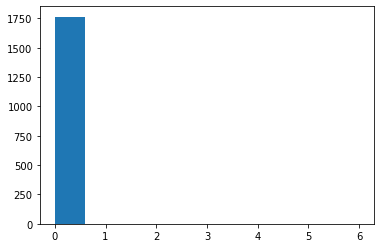

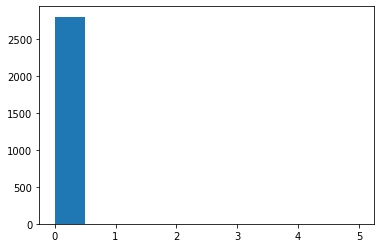

In [497]:
i = 19
plt.hist(kmers[bam_mappings[bam_mappings.sex_numeric=='2.0'].index].iloc[i])
plt.figure()
plt.hist(kmers[bam_mappings[bam_mappings.sex_numeric=='1.0'].index].iloc[i])


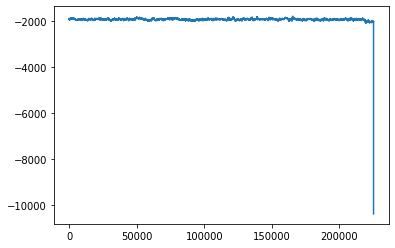

In [492]:
plt.plot(cum_likelihoods[0])#[:200000])

# Debug

In [60]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import json
import sys
import pickle
import numpy as np
from scipy.stats import poisson
import time
import sys
import pandas as pd

# Set up file locations.
IDX = 12
KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/kmers_unmapped_prev_and_median_filt_counts.tsv'
N_KMERS = 10


PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'


###################################################################
#################### Loading files. ##############################
###################################################################
print("Loading in files...")
# Load in family region/global region conversion data.
fam_region_to_idx = np.load(PHASINGS_DIR +  'fam_region_to_idx.npy', allow_pickle=True).item()
family_info = pd.read_pickle(PHASINGS_DIR + 'fam_list.df')

# Info from BAM mappings.
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']

# This sample is messed up in the unmapped reads, 
if 'unmapped' in KMER_COUNTS_FILE:
    bam_mappings = bam_mappings.drop('09C86428')

# Load in k-mer counts.
family = family_info.index[IDX]
print('family ', family)
samples = [family_info.iloc[IDX]['mother_sample'], family_info.iloc[IDX]['father_sample']] +  family_info.iloc[IDX]['sib_samples']
bam_mappings['counter_idx'] = [i for i in range(len(bam_mappings))]
cols_in_df = bam_mappings.loc[samples].counter_idx.values
print(samples)

###################################################################
#### Prep dict for normalizing k-counts by sample read depth. #####
###################################################################
kmer_length=100
ihart_flagstat_file = '/home/groups/dpwall/briannac/blood_microbiome/data/ihart_flagstat.csv'
flagstat = pd.read_csv(ihart_flagstat_file, index_col=0)
flagstat = flagstat.loc[set(flagstat.index).intersection(bam_mappings.index)]
sex = bam_mappings.loc[flagstat.index].sex_numeric
#bam_mappings = bam_mappings.loc[set(flagstat.index).intersection(bam_mappings.index)]
total_mapped_reads = flagstat.ProperPair*((flagstat.Total_Reads-flagstat.Supplementary-flagstat.Duplicates)/flagstat.Total_Reads)
avg_coverage = total_mapped_reads*150/(6.27e9*(sex.astype(float)==1.0) + 6.37e9*(sex.astype(float)==2.0))
avg_n_100mers = (150-kmer_length)/(150/avg_coverage)
kmer_depth_dict = {k:avg_n_100mers[k] if k in avg_n_100mers else np.mean(avg_n_100mers.values) for k in bam_mappings.index}
avg_k_depth = np.mean(list(kmer_depth_dict.values()))

###########################################################
####### Set up poisson cache and access function. ########
###########################################################
print("Setting up poisson cache...")
max_count = 40
eps = 1e-20
possible_repeats = {0,1}
with open('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/phased_fams_all.pickle', 'rb') as f:
    phased_fam_dict = pickle.load(f)
family_phasings = sorted(list(set([tuple(v) for v in phased_fam_dict[family].values])))
poisson_cache = {}
avg_kmer_depth=np.mean(list(kmer_depth_dict.values()))
for i in (possible_repeats):
    for j in possible_repeats:
        if j>i: 
            for k in range(max_count):
                prob = poisson.pmf(k=k, mu=int(i+j)*avg_kmer_depth)
                if prob>eps: poisson_cache[(i+j, k)] = prob
    
def cached_poisson_pmf(k,g):
    if (g==0) & (k!=0): return eps
    if (g==0) & (k==0): return 1-3*eps
    if (g,k) not in poisson_cache: return eps
    return min(max(poisson_cache[g,k], eps), 1-3*eps)

Loading in files...
family  AU0043
['03C15803', '03C15850', '03C14330', '03C15851', '03C15852']
Setting up poisson cache...


In [61]:
###########################################################
#### Computing phasing x global region Presence matrix ####
###########################################################
print("Computing phasing x global region presence matrix...")
family_phasings_to_idx_dict = {p:i for i,p in enumerate(family_phasings)}
global_regions_phasings_fam = np.zeros((len(global_region_to_idx),len(family_phasings))) 

for k,v in pd.DataFrame(phased_fam_dict[family].apply(lambda x: tuple(x), axis=1)).iterrows():
    for i in fam_idx_to_global_idx[fam_region_to_idx[k]]:
        global_regions_phasings_fam[i,family_phasings_to_idx_dict[v[0]]] = 1
        
# If we don't know the phasing, then default to most common phasing.
# Doing it this way will assign unknown regions the most common likelihood of the whole family's genome.
# If we didn't do this, we would end up with have the log-likelihood=0 at regions w/unknown phases, this will give unknown regions an unfair advantage.
impute_vector = np.zeros(len(family_phasings))
impute_vector[np.argmax(global_regions_phasings_fam.sum(axis=0))] = 1

#impute_vector = np.apply_along_axis(arr=global_regions_phasings_fam[np.where(global_regions_phasings_fam.sum(axis=1)!=0)[0], :], func1d=np.median, axis=0)
for i in np.where(global_regions_phasings_fam.sum(axis=1)==0)[0]:
    global_regions_phasings_fam[i,:]=impute_vector
 

Computing phasing x global region presence matrix...


In [215]:
phases_ch = ((9, 9), (8, 8), (9, 9))
phases_ch = ((0, 0), (1, 0), (1, 0))
kmer_count_set = (2, 0, 0, 2, 3)
# sexes = 2 1 1 2 1 
if True:
        if (max([f for ff in phases_ch for f in ff]) > 3) & (max([f for ff in phases_ch for f in ff]) < 8):
            phases_ch_compute = [(f-4,g-4) for f,g in phases_ch]
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] # Include possible repeats!
            possible_gs_dad = [(mat_gt,0) for mat_gt in possible_repeats] 

        # If Y chromosome:
        elif (max([f for ff in phases_ch for f in ff]) > 7):
            print('jere')
            phases_ch_compute = [(f-8,g-8) for f,g in phases_ch]
            possible_gs_mom = [(0,0)] 
            possible_gs_dad = [(0,pat_gt) for pat_gt in possible_repeats] 

            
        # Autosome or PAR
        else :
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] 
            possible_gs_dad = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] 
            phases_ch_compute =  phases_ch


k_m = kmer_count_set[0]
k_p = kmer_count_set[1]
k_cs = kmer_count_set[2:]
print(round(np.log2(np.mean(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_p in possible_gs_mom for g_m in possible_gs_dad])),3))

-24.435


TypeError: object of type 'generator' has no len()

In [197]:
k_m = kmer_count_set[0]
k_p = kmer_count_set[1]
k_cs = kmer_count_set[2:]
print(round(np.log2(np.max(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_p in possible_gs_mom for g_m in possible_gs_dad])),3))

-28.862


In [190]:
max([cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_p in possible_gs_mom for g_m in possible_gs_dad])

0.04977113674337245

In [108]:
possible_gs_dad

[(0, 0), (0, 1)]

In [79]:
# 2 1 1 2 1
kmer_count_set

(2, 0, 0, 2, 3)

In [67]:
import pdb
print("Computing phasing x k-mer region likelihood matrix...")
phases_kmers_L = np.zeros((N_KMERS,len(family_phasings)))  # Initializ likelihood matrix (phases as rows, kmers as columns)
chunks = pd.read_table(KMER_COUNTS_FILE, header=None,  chunksize=10000, usecols=1+cols_in_df, nrows=N_KMERS)

for kmer_counts in chunks:
    kmer_counts = kmer_counts[1+cols_in_df]
    kmer_counts.columns = samples
    print(kmer_counts.index[0])
    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
    kmer_counts = kmer_counts[((kmer_counts>0).sum(axis=1)>0)]
    kmer_counts_normed = kmer_counts.apply(lambda x: x*norm_mult, axis=1)
    kmer_counts_normed = kmer_counts_normed.apply(lambda x: np.round(x/(10**np.floor(np.log10(max(x[x>0]))))), axis=1).astype(int)
    kmer_counts_normed = kmer_counts_normed.applymap(lambda x: min(x,max_count))
    poss_kmer_counts = set([tuple(v) for v in kmer_counts_normed.values])
    family_probability_cache = dict()
    print(family_phasings)
    
    for phases_ch in family_phasings:
        print(phases_ch)
        # If X chromosome:
        if (max([f for ff in phases_ch for f in ff]) > 3) & (max([f for ff in phases_ch for f in ff]) < 8):
            phases_ch_compute = ((f-4,g-4) for f,g in phases_ch)
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] # Include possible repeats!
            possible_gs_dad = [(mat_gt,0) for mat_gt in possible_repeats for pat_gt in possible_repeats] 

        # If Y chromosome:
        elif (max([f for ff in phases_ch for f in ff]) > 7):
            phases_ch_compute = ((f-8,g-8) for f,g in phases_ch)
            possible_gs_mom = [(0,0) for mat_gt in possible_repeats for pat_gt in possible_repeats] 
            possible_gs_dad = [(0,pat_gt) for pat_gt in possible_repeats for mat_gt in possible_repeats] 

            
        # Autosome or PAR
        else :
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] 
            possible_gs_dad = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] 
            phases_ch_compute =  phases_ch
            
        for kmer_count_set in (poss_kmer_counts):
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(sum(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch_compute)]
                        ) for g_m in possible_gs_mom for g_p in possible_gs_dad])),3)
    pdb.set_trace()
    print('Done making cached dictionary.')
    # Compute likelihood matrix (phasings x kmers)
    for i,p in enumerate(family_phasings):
        phases_kmers_L[kmer_counts_normed.index, i] = [family_probability_cache[(k, p)] for k in kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values]
    print('Done compute likelihood matrix')


Computing phasing x k-mer region likelihood matrix...
0
[((0, 0), (0, 0), (0, 0)), ((0, 0), (0, 1), (0, 0)), ((0, 0), (1, 0), (0, 0)), ((0, 0), (1, 1), (0, 0)), ((0, 1), (0, 0), (0, 0)), ((0, 1), (0, 1), (0, 0)), ((0, 1), (1, 0), (0, 0)), ((0, 1), (1, 1), (0, 0)), ((1, 0), (0, 0), (0, 0)), ((1, 0), (0, 1), (0, 0)), ((1, 0), (1, 0), (0, 0)), ((1, 0), (1, 1), (0, 0)), ((1, 1), (0, 0), (0, 0)), ((1, 1), (0, 1), (0, 0)), ((1, 1), (1, 0), (0, 0)), ((1, 1), (1, 1), (0, 0)), ((4, 4), (4, 5), (4, 4)), ((4, 4), (5, 5), (4, 4)), ((5, 4), (4, 5), (4, 4)), ((5, 4), (5, 5), (4, 4)), ((9, 9), (8, 8), (9, 9))]
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 1), (0, 0))
((0, 0), (1, 0), (0, 0))
((0, 0), (1, 1), (0, 0))
((0, 1), (0, 0), (0, 0))
((0, 1), (0, 1), (0, 0))
((0, 1), (1, 0), (0, 0))
((0, 1), (1, 1), (0, 0))
((1, 0), (0, 0), (0, 0))
((1, 0), (0, 1), (0, 0))
((1, 0), (1, 0), (0, 0))
((1, 0), (1, 1), (0, 0))
((1, 1), (0, 0), (0, 0))
((1, 1), (0, 1), (0, 0))
((1, 1), (1, 0), (0, 0))
((1, 1), (1, 1), (0, 0

(Pdb)  kmer_counts


   03C15803  03C15850  03C14330  03C15851  03C15852
0         8         0         0        12        13
3         0         3         0         0         8
5         2         0         0         2         4
6         2         0         0         4         0
8         0         2         3         2         2


(Pdb)  kmers_normed


*** NameError: name 'kmers_normed' is not defined


(Pdb)  kmer_counts_normed


   03C15803  03C15850  03C14330  03C15851  03C15852
0         1         0         0         1         1
3         0         3         0         0         7
5         2         0         0         2         3
6         2         0         0         3         0
8         0         2         3         2         2


(Pdb)  family_probability_cache


{((2, 0, 0, 3, 0), ((0, 0), (0, 0), (0, 0))): -28.525, ((0, 3, 0, 0, 7), ((0, 0), (0, 0), (0, 0))): -27.101, ((1, 0, 0, 1, 1), ((0, 0), (0, 0), (0, 0))): -30.029, ((0, 2, 3, 2, 2), ((0, 0), (0, 0), (0, 0))): -20.346, ((2, 0, 0, 2, 3), ((0, 0), (0, 0), (0, 0))): -24.435, ((2, 0, 0, 3, 0), ((0, 0), (0, 1), (0, 0))): -20.111, ((0, 3, 0, 0, 7), ((0, 0), (0, 1), (0, 0))): -18.687, ((1, 0, 0, 1, 1), ((0, 0), (0, 1), (0, 0))): -30.038, ((0, 2, 3, 2, 2), ((0, 0), (0, 1), (0, 0))): -81.456, ((2, 0, 0, 2, 3), ((0, 0), (0, 1), (0, 0))): -24.444, ((2, 0, 0, 3, 0), ((0, 0), (1, 0), (0, 0))): -11.693, ((0, 3, 0, 0, 7), ((0, 0), (1, 0), (0, 0))): -26.109, ((1, 0, 0, 1, 1), ((0, 0), (1, 0), (0, 0))): -82.172, ((0, 2, 3, 2, 2), ((0, 0), (1, 0), (0, 0))): -20.354, ((2, 0, 0, 2, 3), ((0, 0), (1, 0), (0, 0))): -79.075, ((2, 0, 0, 3, 0), ((0, 0), (1, 1), (0, 0))): -11.697, ((0, 3, 0, 0, 7), ((0, 0), (1, 1), (0, 0))): -18.691, ((1, 0, 0, 1, 1), ((0, 0), (1, 1), (0, 0))): -37.456, ((0, 2, 3, 2, 2), ((0, 0), 

(Pdb)  kmers_normed


*** NameError: name 'kmers_normed' is not defined


(Pdb)  exit


BdbQuit: 

In [82]:
global_regions_phasings

,0,1,2,3,4,5,6,7,8,9,...,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225309,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
225310,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
225311,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
225312,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


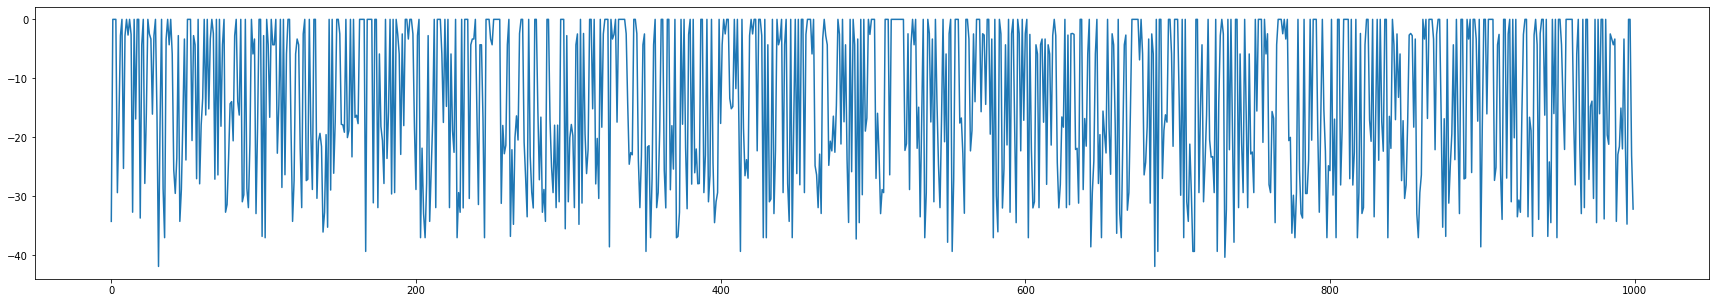

In [15]:
plt.figure(figsize=(30,5))
plt.plot(likelihood_matrix_phasings_kmers[0])

In [2]:
from scipy.stats import poisson
###########################################################
####### Set up poisson cache and access function. ########
###########################################################
print("Setting up poisson cache...")
max_count = 40
eps = 1e-20
possible_repeats = {0,1,2}
with open('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/phased_fams_all.pickle', 'rb') as f:
    phased_fam_dict = pickle.load(f)
family_phasings = sorted(list(set([tuple(v) for v in phased_fam_dict[family].values])))
poisson_cache = {}
avg_kmer_depth=np.mean(list(kmer_depth_dict.values()))
for i in (possible_repeats):
    for j in possible_repeats:
        if j>i: 
            for k in range(max_count):
                prob = poisson.pmf(k=k, mu=int(i+j)*avg_kmer_depth)
                if prob>eps: poisson_cache[(i+j, k)] = prob
    
def cached_poisson_pmf(k,g):
    if (g==0) & (k!=0): return eps
    if (g==0) & (k==0): return 1-3*eps
    if (g,k) not in poisson_cache: return eps
    return min(max(poisson_cache[g,k], eps), 1-3*eps)

###########################################################
#### Computing phasing x global region Presence matrix ####
###########################################################
print("Computing phasing x global region presence matrix...")
family_phasings_to_idx_dict = {p:i for i,p in enumerate(family_phasings)}
global_regions_phasings_fam = np.zeros((len(global_region_to_idx),len(family_phasings))) 

for k,v in pd.DataFrame(phased_fam_dict[family].apply(lambda x: tuple(x), axis=1)).iterrows():
    for i in fam_idx_to_global_idx[fam_region_to_idx[k]]:
        global_regions_phasings_fam[i,family_phasings_to_idx_dict[v[0]]] = 1
        
# If we don't know the phasing, then default to most common phasing.
# Doing it this way will assign unknown regions the most common likelihood of the whole family's genome.
# If we didn't do this, we would end up with have the log-likelihood=0 at regions w/unknown phases, this will give unknown regions an unfair advantage.
impute_vector = np.zeros(len(family_phasings))
impute_vector[np.argmax(global_regions_phasings_fam.sum(axis=0))] = 1

#impute_vector = np.apply_along_axis(arr=global_regions_phasings_fam[np.where(global_regions_phasings_fam.sum(axis=1)!=0)[0], :], func1d=np.median, axis=0)
for i in np.where(global_regions_phasings_fam.sum(axis=1)==0)[0]:
    global_regions_phasings_fam[i,:]=impute_vector
 

print("Computing phasing x k-mer region likelihood matrix...")
phases_kmers_L = np.zeros((N_KMERS,len(family_phasings)))  # Initializ likelihood matrix (phases as rows, kmers as columns)
chunks = pd.read_table(KMER_COUNTS_FILE, header=None,  chunksize=10000, usecols=1+cols_in_df, nrows=N_KMERS)

for kmer_counts in chunks:
    kmer_counts = kmer_counts[1+cols_in_df]
    kmer_counts.columns = samples
    print(kmer_counts.index[0])
    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
    kmer_counts = kmer_counts[((kmer_counts>0).sum(axis=1)>0)]
    kmer_counts_normed = kmer_counts.apply(lambda x: x*norm_mult, axis=1)
    kmer_counts_normed = kmer_counts_normed.apply(lambda x: np.round(x/(10**np.floor(np.log10(max(x[x>0]))))), axis=1).astype(int)
    kmer_counts_normed = kmer_counts_normed.applymap(lambda x: min(x,max_count))
    poss_kmer_counts = set([tuple(v) for v in kmer_counts_normed.values])
    family_probability_cache = dict()
    print(family_phasings)
    for phases_ch in family_phasings:
        # If X chromosome:
        if (max([f for ff in phases_ch for f in ff]) > 3) & (max([f for ff in phases_ch for f in ff]) < 8):
            phases_ch = [(f-4,g-4) for f,g in phases_ch]
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] # Include possible repeats!
            possible_gs_dad = [(mat_gt,0) for mat_gt in possible_repeats] # Include possible repeats!

        # If Y chromosome:
        elif (max([f for ff in phases_ch for f in ff]) > 7):
            phases_ch = [(f-8,g-8) for f,g in phases_ch]
            possible_gs_mom = [(0,0)] # Include possible repeats!
            possible_gs_dad = [(0,pat_gt) for pat_gt in possible_repeats] # Include possible repeats!

        # Autosome or PAR
        else :
            possible_gs_mom = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] # Include possible repeats!
            possible_gs_dad = [(mat_gt,pat_gt) for mat_gt in possible_repeats for pat_gt in possible_repeats] # Include possible repeats!

        print('possible kmer counts:', len(poss_kmer_counts))    
        for kmer_count_set in (poss_kmer_counts):
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(sum(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch)]
                        ) for g_p in possible_gs_mom for g_m in possible_gs_dad])),3)

    print('Done making cached dictionary.')
    # Compute likelihood matrix (phasings x kmers)
    for i,p in enumerate(family_phasings):
        phases_kmers_L[kmer_counts_normed.index, i] = [family_probability_cache[(k, p)] for k in kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values]
    print('Done compute likelihood matrix')

Setting up poisson cache...
Computing phasing x global region presence matrix...
